### Imports 

In [46]:
import os 
import sys
import pathlib
import requests
from io import StringIO, BytesIO
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [47]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [48]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [49]:
import seaborn as sns

In [50]:
import numpy as np
import pandas as pd

### Some parameters 

### number of months to keep (last 12)

In [51]:
n_months = 12

In [52]:
year = 2020

In [53]:
month = 9

In [54]:
enso_tracker_path = '../template/'

In [55]:
figures_path = './figures'

In [56]:
if not pathlib.Path(figures_path).exists(): 
    pathlib.Path(figures_path).mkdir(parents=True)

In [57]:
last_valid = datetime(year, month, 1)

In [58]:
last_valid = last_valid + pd.offsets.MonthEnd(0) 

In [59]:
last_valid

Timestamp('2020-09-30 00:00:00')

In [60]:
start_date = last_valid - relativedelta(months=n_months)

In [61]:
start_date

Timestamp('2019-09-30 00:00:00')

### Access and read the NINO3.4 index from the BoM 

In [62]:
def get_BoM_NINO(nino="3.4", base_url = "http://www.bom.gov.au/climate/enso/", start_date=None, end_date=None): 
    """
    Get the NINO 3.4 index from the BoM
    """
    
    from datetime import datetime, timedelta
    from dateutil.relativedelta import relativedelta
    import numpy as np 
    import pandas as pd
    
    url_nino = f"{base_url}/nino_{nino}.txt"
    r = requests.get(url_nino)

    if r.status_code != 200: 
        print(f"something went wrong with accessing the URL {url_nino}")

    else: 
        # read the weekly NINO index, and assign the end date of the weekly period 
        nino_index = pd.read_table(BytesIO(r.content), sep=',', header=None, index_col=1, parse_dates=True, names=['iDate','SST'])

    nino_index = nino_index.resample('1M').mean()
    
    if not (start_date == end_date == None):
        nino_index = nino_index.loc[start_date:end_date,:]
    else: 
        start_date = (datetime.utcnow() - timedelta(15)) - relativedelta(months=n_months)
        nino_index = nino_index.loc[start_date:,:]
    
    return nino_index 

In [63]:
def get_LP_SOI(url='https://data.longpaddock.qld.gov.au/SeasonalClimateOutlook/SouthernOscillationIndex/SOIDataFiles/DailySOI1933-1992Base.txt', start_date=None, end_date=None): 
    """
    get the SOI from LongPaddock
    """
    
    from datetime import datetime, timedelta
    from dateutil.relativedelta import relativedelta
    import numpy as np 
    import pandas as pd
    
    r = requests.get(url)

    if r.status_code != 200: 
        print(f"something went wrong with accessing the URL {url_soi}")
    else: 
        soi_index = pd.read_table(BytesIO(r.content), sep='\s+', engine='python') 
        
    index = [datetime(int(year),1,1) + timedelta(int(day)-1) for year, day in soi_index.loc[:,['Year','Day']].values]
    soi_index.index = index
    soi_index = soi_index.resample('1M').mean()

    if not (start_date == end_date == None):
        soi_index = soi_index.loc[start_date:end_date,:]
    else: 
        start_date = (datetime.utcnow() - timedelta(15)) - relativedelta(months=n_months)
        soi_index = soi_index.loc[start_date:,:]
    
    return soi_index

In [64]:
def read_ENSO_categories(dpath = '../template', fname = 'Pacific_RCC_ENSO_tracker.csv'): 
    
    import pathlib
    import numpy as np 
    import pandas as pd 
    
    filename = pathlib.Path(dpath).joinpath(fname)
    
    enso_cat = pd.read_csv(filename)
    
    # goes from string to categories 
    cat_to_int = {} 

    cat_to_int['La_Nina'] = -3
    cat_to_int['La_Nina_alert'] = -2
    cat_to_int['La_Nina_watch'] = -1
    cat_to_int['neutral'] = 0
    cat_to_int['El_Nino_watch'] = 1 
    cat_to_int['El_Nino_alert'] = 2 
    cat_to_int['El_Nino'] = 3
    
    enso_cat_int = enso_cat.replace(cat_to_int)
    
    enso_cat_int.loc[:,'date'] = np.NaN
    
    # build the index 
    enso_cat_int.loc[:,'date'] = enso_cat_int.loc[:,'YEAR'].astype(str) + "-" + enso_cat_int.loc[:,'MONTH'].astype(str).str.zfill(2)
    
    enso_cat_int = enso_cat_int.set_index('date').drop(['YEAR','MONTH'],axis=1) 
    
    enso_cat_int.index = pd.to_datetime(enso_cat_int.index) + pd.offsets.MonthEnd(0) 
    
    return enso_cat_int

In [65]:
nino_index = get_BoM_NINO(start_date=start_date, end_date=last_valid)

/anaconda3/envs/weather2/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: read_table is deprecated, use read_csv instead.


In [66]:
nino_index

,iDate,SST
2019-09-30,20190895.20,0.0040
2019-10-31,20190993.00,0.5375
2019-11-30,20191090.25,0.6375
2019-12-31,20191195.00,0.4100
2020-01-31,20197892.25,0.4475
2020-02-29,20200189.25,0.3000
2020-03-31,20200294.80,0.3900
2020-04-30,20200392.25,0.5375
2020-05-31,20200497.00,-0.0260
2020-06-30,20200611.50,-0.1250


In [67]:
soi_index = get_LP_SOI(start_date=start_date, end_date=last_valid)

/anaconda3/envs/weather2/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: read_table is deprecated, use read_csv instead.
  app.launch_new_instance()


In [68]:
soi_index

,Year,Day,Tahiti,Darwin,SOI
2019-09-30,2019.0,258.5,1014.775667,1014.486667,-12.461000
2019-10-31,2019.0,289.0,1013.416129,1011.408065,-5.513226
2019-11-30,2019.0,319.5,1011.153333,1009.748333,-9.927333
2019-12-31,2019.0,350.0,1010.825484,1008.416129,-5.456774
2020-01-31,2020.0,16.0,1011.896129,1007.211290,1.214839
2020-02-29,2020.0,46.0,1011.524828,1007.375862,-1.992069
2020-03-31,2020.0,76.0,1012.074839,1009.119355,-5.370968
2020-04-30,2020.0,106.5,1012.804667,1010.546667,-0.756000
2020-05-31,2020.0,137.0,1014.314194,1012.350000,2.559677
2020-06-30,2020.0,167.5,1012.901333,1012.945000,-9.908667


### check 

In [69]:
if len(soi_index) != len(nino_index): 
    print(f"check the SOI and NINO3.4 index data, the SOI Index has length {len(soi_index)} and the NINO Index has length {len(nino_index)}")

### merge the NINO and SOI index 

In [70]:
ENSO_index = pd.concat([nino_index, soi_index], axis=1)

In [71]:
ENSO_index = ENSO_index.dropna()

In [72]:
ENSO_index.head()

,iDate,SST,Year,Day,Tahiti,Darwin,SOI
2019-09-30,20190895.20,0.0040,2019.0,258.5,1014.775667,1014.486667,-12.461000
2019-10-31,20190993.00,0.5375,2019.0,289.0,1013.416129,1011.408065,-5.513226
2019-11-30,20191090.25,0.6375,2019.0,319.5,1011.153333,1009.748333,-9.927333
2019-12-31,20191195.00,0.4100,2019.0,350.0,1010.825484,1008.416129,-5.456774
2020-01-31,20197892.25,0.4475,2020.0,16.0,1011.896129,1007.211290,1.214839


In [73]:
ENSO_index.tail()

,iDate,SST,Year,Day,Tahiti,Darwin,SOI
2020-05-31,20200497.00,-0.0260,2020.0,137.0,1014.314194,1012.350000,2.559677
2020-06-30,20200611.50,-0.1250,2020.0,167.5,1012.901333,1012.945000,-9.908667
2020-07-31,20200692.00,0.0425,2020.0,198.0,1014.284194,1012.708065,4.016452
2020-08-31,20200796.20,-0.4160,2020.0,229.0,1015.644194,1012.501613,9.394194
2020-09-30,20200893.25,-0.7125,2020.0,259.5,1015.658667,1011.643333,9.960333


### selects only the columns we actually need 

In [74]:
ENSO_index = ENSO_index.loc[:,['SST','SOI']]

### divides the SOI by 10 to get something closer to the NIWA SOI 

In [75]:
ENSO_index.loc[:,'SOI'] /= 10.

In [76]:
ENSO_index.head()

,SST,SOI
2019-09-30,0.0040,-1.246100
2019-10-31,0.5375,-0.551323
2019-11-30,0.6375,-0.992733
2019-12-31,0.4100,-0.545677
2020-01-31,0.4475,0.121484


In [77]:
ENSO_index.tail()

,SST,SOI
2020-05-31,-0.0260,0.255968
2020-06-30,-0.1250,-0.990867
2020-07-31,0.0425,0.401645
2020-08-31,-0.4160,0.939419
2020-09-30,-0.7125,0.996033


### get the last date 

In [78]:
last_date = pd.to_datetime(ENSO_index.index[-1])

In [79]:
last_date

Timestamp('2020-09-30 00:00:00', freq='M')

### get the values and the basis for plotting

In [80]:
soi_values = ENSO_index.SOI.values

In [81]:
nino_values = ENSO_index.SST.values 

In [82]:
basis = np.arange(len(ENSO_index))

### build the list of dates for X-axis labeling 

In [83]:
dates = ENSO_index.index.to_pydatetime()

In [84]:
dates_str = [f"{x:%b %Y}" for x in dates]

### Now read the ENSO categories from NOAA, BoM, APCC and NOAA

In [85]:
enso_cat_int = read_ENSO_categories()

In [86]:
ENSO_index

,SST,SOI
2019-09-30,0.0040,-1.246100
2019-10-31,0.5375,-0.551323
2019-11-30,0.6375,-0.992733
2019-12-31,0.4100,-0.545677
2020-01-31,0.4475,0.121484
2020-02-29,0.3000,-0.199207
2020-03-31,0.3900,-0.537097
2020-04-30,0.5375,-0.075600
2020-05-31,-0.0260,0.255968
2020-06-30,-0.1250,-0.990867


In [87]:
enso_cat_int = enso_cat_int.loc[ENSO_index.index,:]

### colors for the heatmap 

In [88]:
col_dict={-3:"#4233ff",
          -2:"#33a2ff",
          -1:"#33ffbb",
          0:"#d4d4d4",
          1:"#f3ff33", 
          2:"#ffa233",
          3:"#dc0f09"
         }

cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

In [89]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

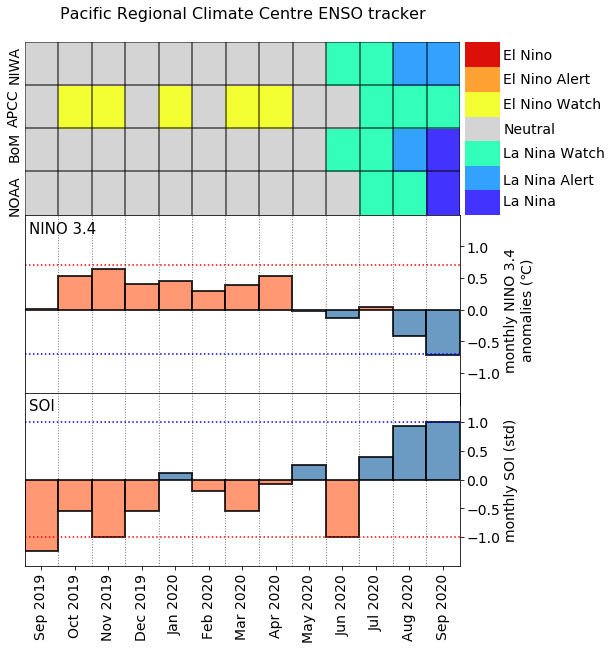

In [90]:
f = plt.figure(figsize=(8,8))

# defines the axes [left, bottom, width, height]

ax0 = f.add_axes([0.1, 0.66, 0.9, 0.3])

ax0.set_title("Pacific Regional Climate Centre ENSO tracker\n", fontsize=16)

ax1 = f.add_axes([0.1, 0.33, 0.755, 0.33])

ax2 = f.add_axes([0.1, 0.05, 0.755, 0.30])

#============================================================================================================================
# first set of axes: ENSO categories heatmap 

sns.heatmap(enso_cat_int.T, cmap=cm, center=0, vmin=-3, vmax=3, ax=ax0, \
            cbar_kws={'aspect':5, 'pad':0.01}) 

colorbar = ax0.collections[0].colorbar 

ax0.set_yticks([0.8, 1.8, 2.8, 3.8]);

ax0.set_yticklabels(['NOAA','BoM','APCC','NIWA'], fontsize=14)

ax0.set_ylim(bottom=0,top=4)

[ax0.axvline(x, color='k', lw=2, alpha=0.5) for x in range(0,len(enso_cat_int) + 1)];

[ax0.axhline(x, color='k', lw=2, alpha=0.5) for x in range(1,5)];

ax0.tick_params(direction='out', length=0, width=0)

colorbar.set_ticks([-2.5, -1.75, -0.8,  0.,  0.90, 1.75,  2.6])

colorbar.set_ticklabels(["La Nina", "La Nina Alert", "La Nina Watch", "Neutral", "El Nino Watch", "El Nino Alert", "El Nino"])    

colorbar.ax.tick_params(direction='out', length=0, width=0)

#============================================================================================================================
# second set of axes: ENSO barplot

ax1.bar(basis[nino_values>=0],nino_values[nino_values>=0], width=1, facecolor='coral', alpha=.8, edgecolor='k', lw=2)
ax1.bar(basis[nino_values<0],nino_values[nino_values<0], width=1, facecolor='steelblue', alpha=.8, edgecolor='k', lw=2)

ax1.set_xticks(basis)

ax1.set_xticklabels(dates_str, rotation=90)

ax1.set_xlim([-0.5,len(dates) - 0.5])

ax1.set_ylim([-1.5, 1.5])

ax1.set_yticks([-1., -0.5, 0, 0.5, 1.])

ax1.axhline(-0.7, ls=':', color='b')
ax1.axhline(0.7, ls=':', color='r')

ax1.yaxis.tick_right()

ax1.set_ylabel('monthly NINO 3.4\nanomalies (℃)', fontsize=14)

ax1.yaxis.set_label_position("right")

[ax1.axvline(x, color='k', lw=1, alpha=0.5, ls=':') for x in np.arange(0.5,len(dates)-0.5)];

ax1.set_xlabel('month', fontsize=14)

ax1.text(0.01, 0.9, 'NINO 3.4', transform=ax1.transAxes, fontsize=15)

#============================================================================================================================
# second set of axes: SOI barplot

ax2.bar(basis[soi_values>=0],soi_values[soi_values>=0], width=1, facecolor='steelblue', alpha=.8, edgecolor='k', lw=2)
ax2.bar(basis[soi_values<0],soi_values[soi_values<0], width=1, facecolor='coral', alpha=.8, edgecolor='k', lw=2)

ax2.set_xticks(basis)

ax2.set_xticklabels(dates_str, rotation=90)

ax2.set_xlim([-0.5,len(dates) - 0.5])

ax2.set_ylim([-1.5, 1.5])

ax2.set_yticks([-1., -0.5, 0, 0.5, 1.])

ax2.axhline(-1, ls=':', color='r')
ax2.axhline(1, ls=':', color='b')

ax2.yaxis.tick_right()

ax2.yaxis.set_label_position("right")

ax2.set_ylabel('monthly SOI (std)', fontsize=14)

ax2.yaxis.set_label_position("right")

ax2.text(0.01, 0.9, 'SOI', transform=ax2.transAxes, fontsize=15)

[ax2.axvline(x, color='k', lw=1, alpha=0.5, ls=':') for x in np.arange(0.5,len(dates)-0.5)];

# f.patch.set_facecolor('0.99')
f.patch.set_facecolor('w')

### saves to file 

In [91]:
f.savefig('../figures/prototype_Pacific_RCC.png', dpi=200, bbox_inches='tight')

In [92]:
f.savefig('./figures/prototype_Pacific_RCC.png', dpi=200, bbox_inches='tight')